In [2]:
%pylab inline
import pandas as pd
import emcee
import time
import os
import sys
import corner
from astropy.constants import au,h,pc,c
import glob
import pickle
import pdb as pdb
from slabspec import make_spec, extract_hitran_data
from flux_calculator import calc_fluxes
from slab_fitter import compute_fluxes, make_rotation_diagram, line_ids_from_hitran, line_ids_from_flux_calculator
from slab_fitter import compute_partition_function, compute_partition_function_co,get_hitran_from_flux_calculator, sf_run
from scipy.optimize import minimize
import random


Populating the interactive namespace from numpy and matplotlib


### Read in data and define run

In [3]:
data=pickle.load(open('fztau_fluxes.p','rb'))

myrun=sf_run(data)

mean(myrun.lineflux_err/myrun.lineflux)

0.3601257221989986

### Define prior, likelihood, posterior.

Note: Posterior is prior x likelihood.  Therefore, log posterior is log prior + log likelihood.

Bayes theorem:
$P(A | B) = \frac{P(B | A) P(A)}{P(B)} \equiv$ posterior $=$ likelihood $*$ prior

$log(posterior) = log(likelihood) + log(prior)$



In [4]:
def logposterior(theta, data, sigma, myrun):

    """                                                                                       
    The natural logarithm of the joint posterior.                                             
                                                                                              
    Args:                                                                                     
        theta (list): a sample containing individual parameter values                        
        data (list): the set of data/observations                                             
        sigma (float): the standard deviation of the data points                              
        x (list): the abscissa values at which the data/model is defined                      
    """

    lp = logprior(theta) # get the prior                                                      

    # if the prior is not finite return a probability of zero (log probability of -inf)       
    if not np.isfinite(lp):
        return -np.inf

    # return the likeihood times the prior (log likelihood plus the log prior)   
    return lp + loglikelihood(theta, data, sigma, myrun)
#-------------------------    
def logprior(theta):
    """                                                                                       
    The natural logarithm of the prior probability.                                           
                                                                                              
    Args:                                                                                     
        theta (list): a sample containing individual parameter values                                                         
    """
    lp = 0.  #initialize log prior

    # unpack the model parameters from the list                                             
    logntot, temp, logomega = theta
#-------------------------    
#First parameter: logntot
    # uniform prior on log of ntot                                                                      
    lognmin = 16.  # lower range of prior                                                        
    lognmax = 24.  # upper range of prior                                                        

    # set prior to 1 (log prior to 0) if in the range and zero (log prior to -inf)
    # outside the range       
    lp = 0. if lognmin < logntot < lognmax else -np.inf
#-------------------------    
#Second parameter: temperature
    # Gaussian prior on temp, except if T<=0                                                                   
    tmu = 750.     # mean of the Gaussian prior                                                 
    tsigma = 100. # standard deviation of the Gaussian prior                                   
    lp -= 0.5*((temp - tmu)/tsigma)**2   #Add log prior due to temperature to lp due to logn.

    # set prior to zero (log prior to -inf) if T<=0       
    if (temp <= 0):
        lp = -np.inf    
#-------------------------    
#Third parameter: Omega
    #Uniform prior on Omega, but with some cutoffs
    logomegamin=-21   #0.001 AU circle at 140 pc
    logomegamax=-12   #20 AU circle at 140 pc
    lpo = 0. if logomegamin < logomega < logomegamax else -np.inf

    lp += lpo #Add log prior due to omega to lp due to temperature,logn

    return lp
#-------------------------    
def loglikelihood(theta, data, sigma, myrun):

    """                                                                                       
    The natural logarithm of the joint likelihood.                                            
                                                                                              
    Args:                                                                                     
        theta (list): a sample containing individual parameter values                        
        data (list): the set of data/observations                                             
        sigma (float): the standard deviation of the data points                              
        x (list): the abscissa values at which the data/model is defined                                       
    """

    # unpack the model parameters from the tuple                                              
    logntot, temp, logomega = theta
    omega=10**logomega
    # evaluate the model (assumes that the model is defined above)           
    md = compute_fluxes(myrun, logntot, temp, omega)
    
    # return the log likelihood  
    return -0.5*np.sum(((md - data)/sigma)**2)

/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


/Users/adammoses/Desktop/astroThesis/slab_fitter/slab_fitter.py:96: RuntimeWarning: overflow encountered in exp
  f_arr[i,:]=2*h.value*c.value*wn0[i]**3./(np.exp(wnfactor[i])-1.0e0)*(1-np.exp(-tau[i,:]))*si2jy*omega


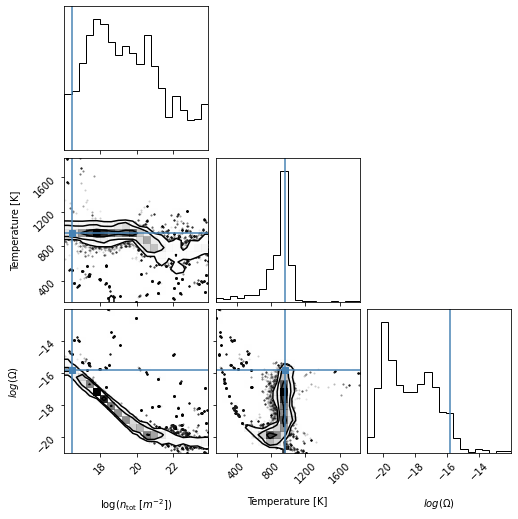

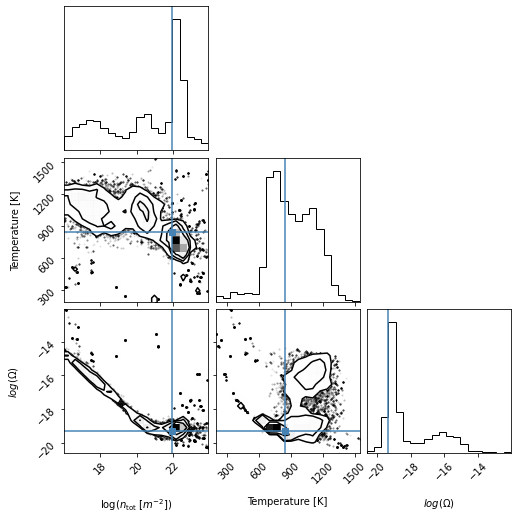

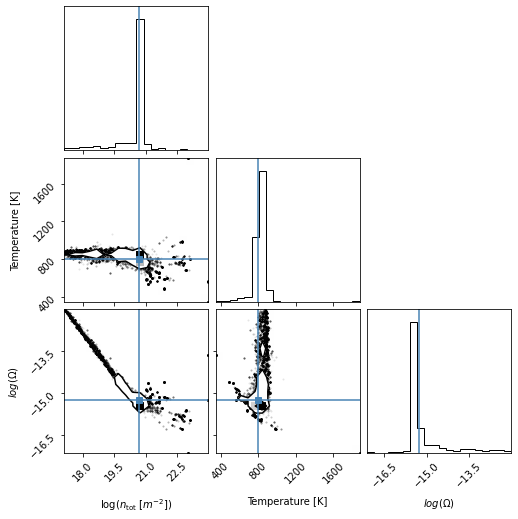

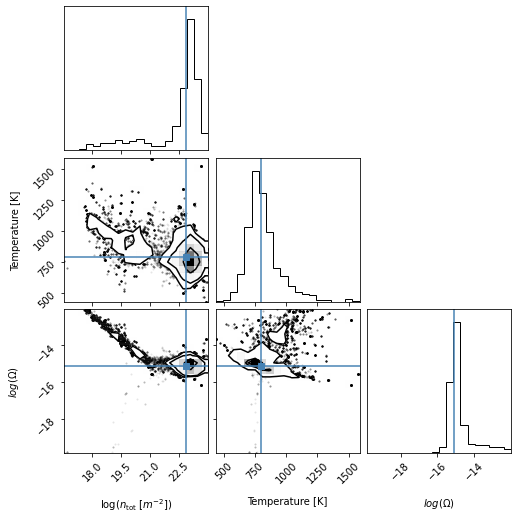

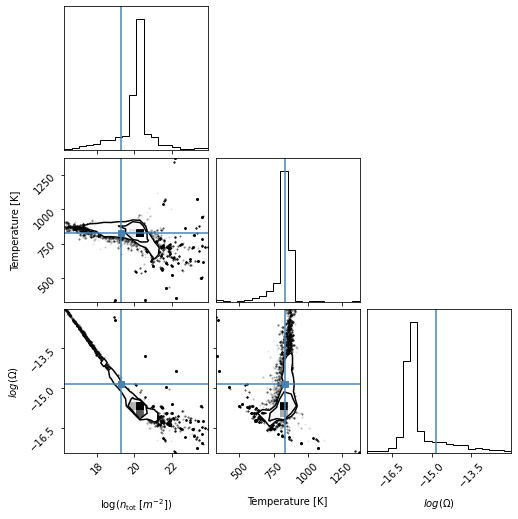

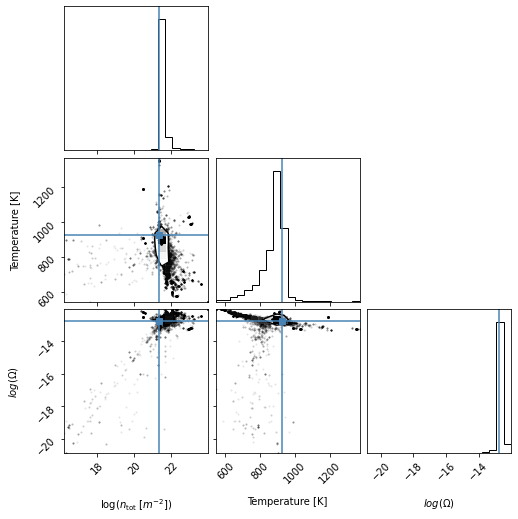

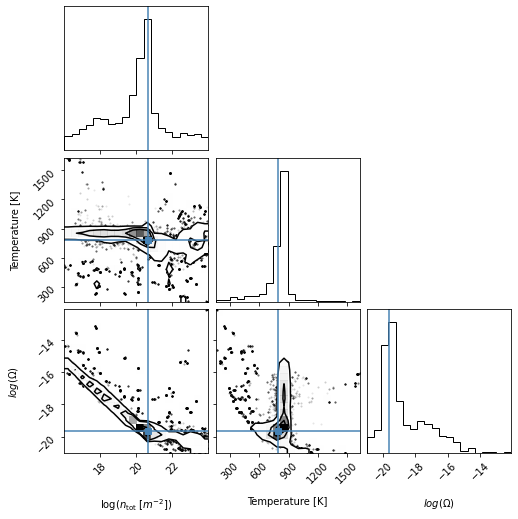

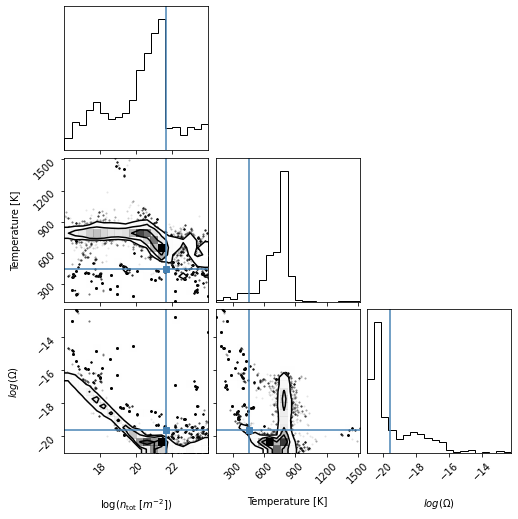

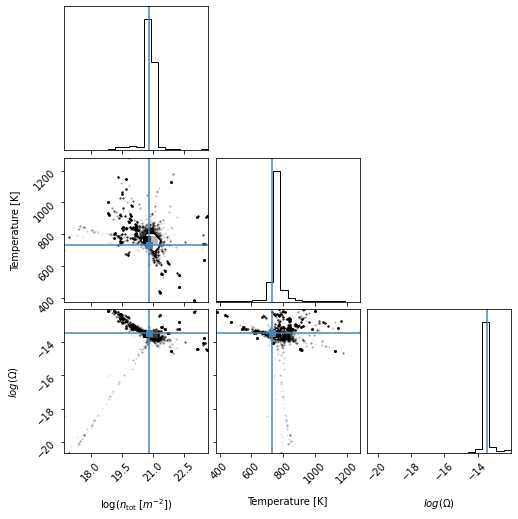

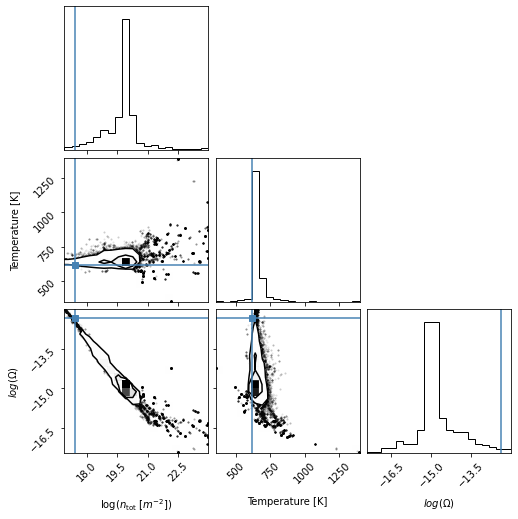

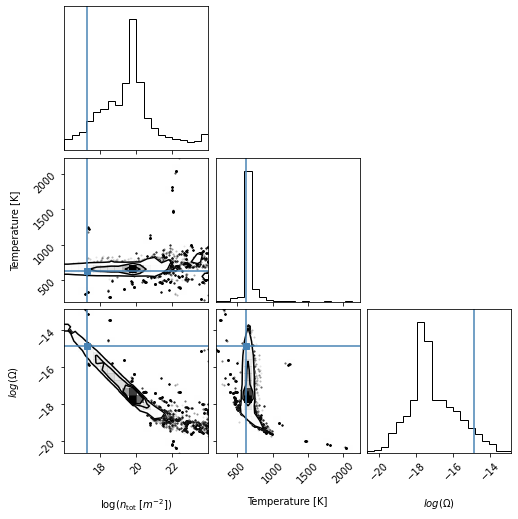

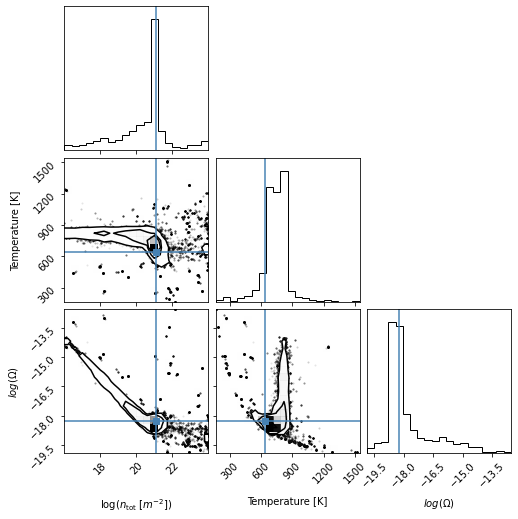

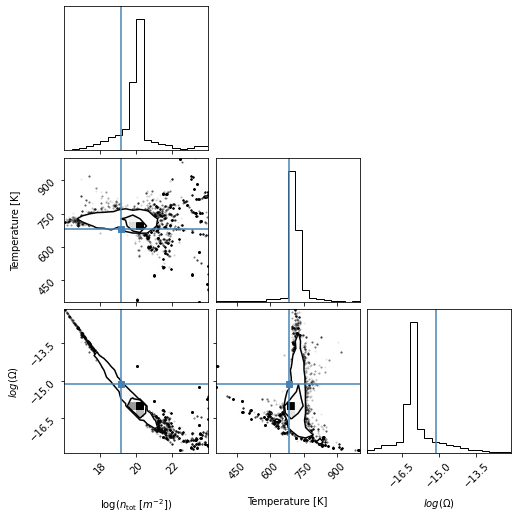

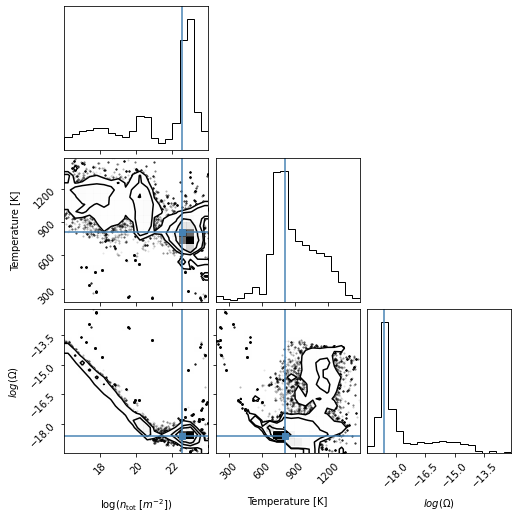

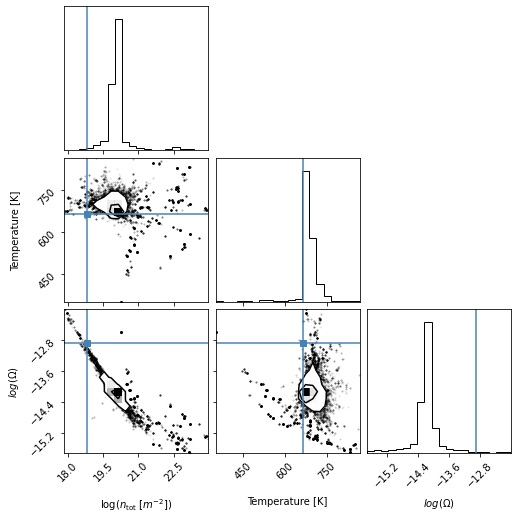

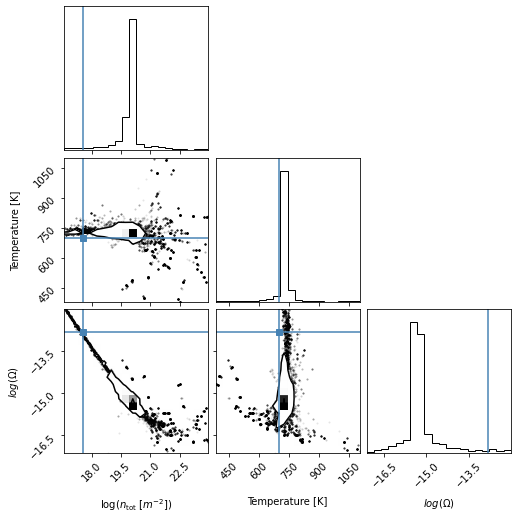

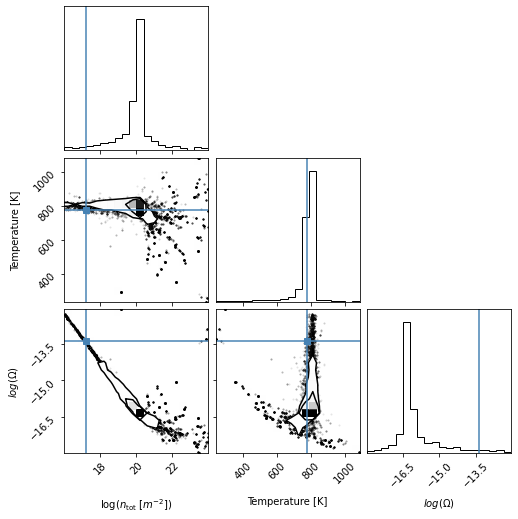

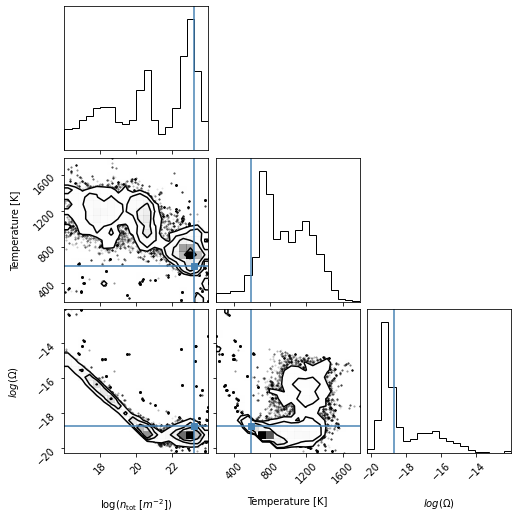

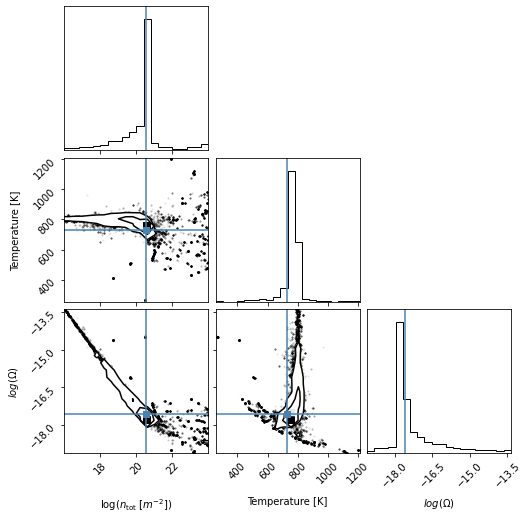

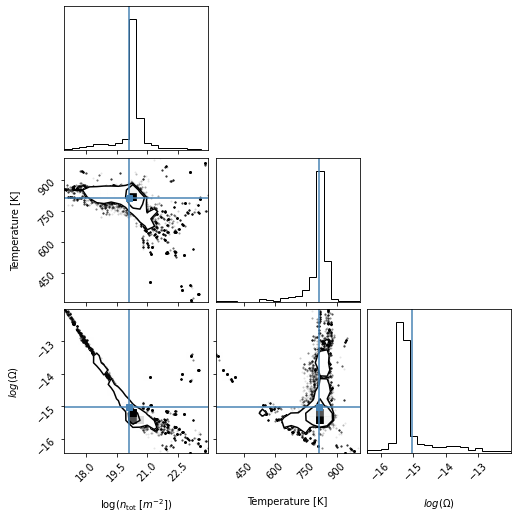

In [28]:
size = 20

distance=140

for k in arange(size):
    
    result = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
    
    # Set random variables
    logn = np.random.random()*8+16
    temp = np.random.normal(750, 100)
    logomega = np.random.random()*9-21
    
    result[0] = round(logn,4)
    result[1] = round(temp,4)
    result[2] = round(logomega,4)
    result[9] = round(distance,4)
    
    # Setting up emcee for each occurence

    Nens = 500   # number of ensemble points                                                         

    #Column density: uniform prior
    lognmin = 16. # lower range of prior                                                        
    lognmax = 24.  # upper range of prior                                                        
    lognini = np.random.uniform(lognmin, lognmax, Nens) # initial logn points                                    

    #Temperature: Gaussian prior
    tmu = 750.     # mean of the Gaussian prior                                                 
    tsigma = 100. # standard deviation of the Gaussian prior                                   
    tini = np.random.normal(tmu, tsigma, Nens) # initial t points                                    

    #Omega: uniform prior    
    logomegamin = -21 # lower range of prior                                                        
    logomegamax = -12  # upper range of prior                                                        
    logomegaini = np.random.uniform(logomegamin, logomegamax, Nens) # initial omegaini points                                    

    inisamples = np.array([lognini, tini, logomegaini]).T # initial samples                                          
    #100 x 2  (Nens x Nparameters)

    ndims = inisamples.shape[1] # number of parameters/dimensions                                    

    Nburnin = 50   # number of burn-in samples                                                      
    Nsamples = 100  # number of final posterior samples 
    
    
    params = np.array([logn, temp, logomega, distance])
    
    # Make spectrum
    spec = make_spec('CO', 10**params[0], params[1], sangle_to_area(10**params[2], params[3]), 
                     wmin=4.6, wmax=5.02, d_pc=distance)
    
    synthdata = spec['lineparams']
    
    synthdata['gup'] = synthdata['gpp']
    del synthdata['gpp']
    
    # Adding error to lineflux measures
    
    mean_lineflux = mean(synthdata['lineflux'])
    
    errorpercent = 0.1

    sigma = np.random.normal(errorpercent, errorpercent*0.3, len(synthdata))*mean_lineflux

    synthdata['lineflux'] += sigma
    synthdata['lineflux_err'] = np.zeros(len(synthdata['lineflux']))+errorpercent*mean_lineflux
  
    # Removing lines that aren't v=1-0
    
    mybool = np.zeros(len(synthdata), dtype=bool)

    for i in arange(len(synthdata)):
        if int(synthdata[i]['Vp']) == 1 and int(synthdata[i]['Vpp']) == 0:
            mybool[i] = True
        
    # Creating run object
    
    synthrun = sf_run(synthdata[mybool])

    # Beginning emcee
    # set additional args for the posterior (the data, the noise std. dev., and the abscissa)        
    argslist = (synthrun.lineflux, synthrun.lineflux_err, synthrun)

    # set up the sampler                                                                             
    sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

    # pass the initial samples and total number of samples required                                  
    start_time=time.time()
    sampler.run_mcmc(inisamples, Nsamples+Nburnin);  
    #initial start points of each walker, total number of samples
    end_time=time.time()
    
    postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

    fig = corner.corner(postsamples, labels=[ r"$\log(n_\mathrm{tot}$ $[m^{-2}])$",r"Temperature [K]", "$log(\Omega)$"], truths=[logn, temp, logomega])
#     fig.text(.7,0.9,'logn = '+str(round(params[0],1)),fontsize=18)
#     fig.text(.7,0.8,'temp = '+str(round(params[1],1)),fontsize=18)
#     fig.text(.7,0.7,'logomega = '+str(round(params[2],1)),fontsize=18)
#     fig.text(.7,0.6,'dist = '+str(round(params[3],1))+'pc',fontsize=18)
    fig.savefig("./SynthSets/Synthetic"+str(k)+".eps")
    
    mcmc_logntot = np.percentile(postsamples[:, 0], [16, 50, 84])
    mcmc_temp = np.percentile(postsamples[:, 1], [16, 50, 84])
    mcmc_log_omega = np.percentile(postsamples[:, 2], [16, 50, 84])
    
    result[3] = round(mcmc_logntot[0],4)
    result[4] = round(mcmc_logntot[2],4)
    result[5] = round(mcmc_temp[0],4)
    result[6] = round(mcmc_temp[2],4)
    result[7] = round(mcmc_log_omega[0],4)
    result[8] = round(mcmc_log_omega[2],4)
    
    string = str(float(result[0]))+','+str(float(result[1]))+','+str(float(result[2]))+','+str(float(result[3]))+','+str(float(result[4]))+','+str(float(result[5]))+','+str(float(result[6]))+','+str(float(result[7]))+','+str(float(result[8]))+','+str(float(result[9]))+'\n'
    
    file = open('synth_results.txt', 'a')
    
    file.write(str(float(result[0]))+','+str(float(result[1]))+','+str(float(result[2]))+','+str(float(result[3]))+','+str(float(result[4]))+','+str(float(result[5]))+','+str(float(result[6]))+','+str(float(result[7]))+','+str(float(result[8]))+','+str(float(result[9]))+'\n')
    file.close()
    
    
    

## Run emcee on real data

In [8]:
Nens = 600   # number of ensemble points                                                         

#Column density: uniform prior
lognmin = 20. # lower range of prior                                                        
lognmax = 24.  # upper range of prior                                                        
lognini = np.random.uniform(lognmin, lognmax, Nens) # initial logn points                                    

#Temperature: Gaussian prior
tmu = 750.     # mean of the Gaussian prior                                                 
tsigma = 100. # standard deviation of the Gaussian prior                                   
tini = np.random.normal(tmu, tsigma, Nens) # initial t points                                    
                                      
#Omega: uniform prior    
logomegamin = -21 # lower range of prior                                                        
logomegamax = -12  # upper range of prior                                                        
logomegaini = np.random.uniform(logomegamin, logomegamax, Nens) # initial omegaini points                                    

inisamples = np.array([lognini, tini, logomegaini]).T # initial samples                                          
#100 x 2  (Nens x Nparameters)

ndims = inisamples.shape[1] # number of parameters/dimensions                                    

Nburnin = 60   # number of burn-in samples                                                      
Nsamples = 120  # number of final posterior samples                                              

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)        
argslist = (myrun.lineflux, myrun.lineflux_err, myrun)

# set up the sampler                                                                             
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

# pass the initial samples and total number of samples required                                  
start_time=time.time()
sampler.run_mcmc(inisamples, Nsamples+Nburnin);  
#initial start points of each walker, total number of samples
end_time=time.time()
print(Nens*(Nsamples+Nburnin), end_time-start_time)

#75000 281 seconds - Vassar machine
#20000 36 seconds - Vassar machine
#20000 73 seconds - personal machine
#4000 12.1 seconds
#2000 5.8 seconds
#200 0.5 seconds - after removing double loop


108000 150.56623530387878


## Maximum Likelihood best-fit

In [9]:
lognguess = 22
tguess = 750
logomegaguess = -16.5

func = lambda *args: -loglikelihood(*args)

thetaguess = np.array([lognguess, tguess, logomegaguess])

MLE = minimize(func, thetaguess, args=(myrun.lineflux, myrun.lineflux_err, myrun))

MLE['x']

array([ 22.92111938, 750.00050856, -14.74265115])

## Corner plot on real data

Number of posterior samples is 72000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

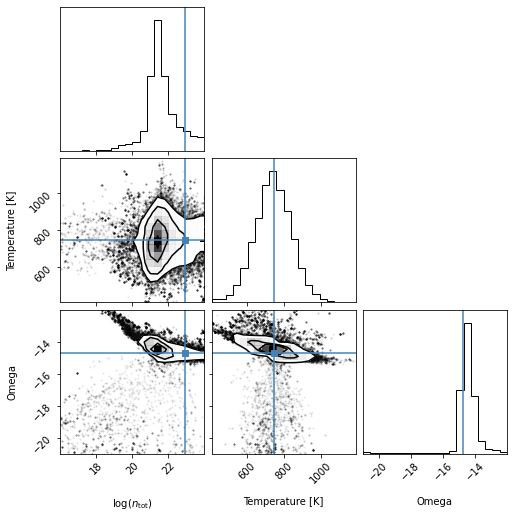

In [10]:
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

fig = corner.corner(postsamples, labels=[ r"$\log(n_\mathrm{tot})$",r"Temperature [K]", "Omega"], truths=MLE['x'])

fig.savefig('MLE.eps')

## Best fit parameters with error bars

In [11]:
from IPython.display import display, Math
labels=[ r"log(Ntot)",r"Temperature", "Omega"]
for i in range(3):
    mcmc = np.percentile(postsamples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Plot of best fit

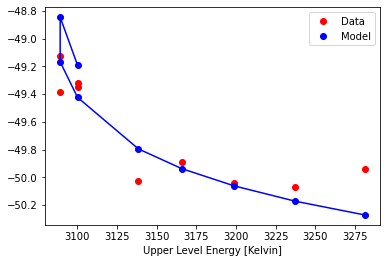

In [12]:
bestfit=[np.percentile(postsamples[:,i],50) for i in range(3)]
modelflux=compute_fluxes(myrun, bestfit[0],bestfit[1],10**(bestfit[2]))
rotdiag=make_rotation_diagram(data,modelfluxes=modelflux)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.set_xlabel('Upper Level Energy [Kelvin]')
ax1.legend()

## Plot of some random samples

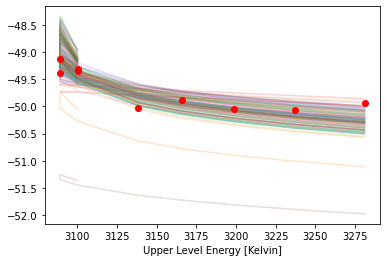

In [13]:

fig=plt.figure()
ax1=fig.add_subplot(111)
inds = np.random.randint(len(postsamples), size=100)
for ind in inds:
    sampley = postsamples[ind]
    modelflux=compute_fluxes(myrun, sampley[0],sampley[1],10.**sampley[2])
    rotdiag=make_rotation_diagram(data,modelfluxes=modelflux)
    ax1.plot(rotdiag['x'],rotdiag['modely'],alpha=0.2)
ax1.set_xlabel('Upper Level Energy [Kelvin]')

bestfit=[np.percentile(postsamples[:,i],50) for i in range(3)]
modelflux=compute_fluxes(myrun, bestfit[0],bestfit[1],10**(bestfit[2]))
rotdiag=make_rotation_diagram(data,modelfluxes=modelflux)
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')